# Face Recognition Model - Complete Implementation

**Formative 2: Data Preprocessing - Image Processing Module**

---

## Overview

This notebook implements a complete face recognition system following the assignment rubrics:

### Tasks Covered:
1. **Exploratory Data Analysis (EDA)** - Statistics, distributions, correlation analysis with labeled plots
2. **Image Quantity & Diversity** - 3 expressions per team member (neutral, smile, surprised)
3. **Image Augmentation** - 8 augmentations per image (rotation, flip, brightness, grayscale, blur)
4. **Feature Extraction** - VGG16 embeddings (512-dimensional features) saved to `image_features.csv`
5. **Model Implementation** - Random Forest classifier for face recognition
6. **Evaluation Metrics** - Accuracy, F1-Score, Log Loss presented in tables
7. **Model Validation** - Confusion matrix and classification report

### Team Members:
- **Alice** - 3 expressions (neutral, smiling, surprised)
- **cedric** - 3 expressions (neutral, smiling, surprised)
- **yassin** - 3 expressions (neutral, smiling, surprised)

**Total:** 9 original images -> 72 augmented samples (9 x 8 augmentations)

---
## 1. Import Required Libraries

Import all necessary libraries for data processing, visualization, and machine learning.

In [22]:
# Core data processing
import numpy as np
import pandas as pd
from pathlib import Path
import time
import json
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Model persistence
import joblib

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print('All libraries imported successfully!')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Scikit-learn: {pd.__version__}')

All libraries imported successfully!
NumPy version: 2.2.6
Pandas version: 2.3.3
Scikit-learn: 2.3.3


---
## 2. Load Dataset

Load the extracted image features from `image_features.csv`. This file contains:
- **Metadata:** user, expression, augmentation type
- **Features:** 512-dimensional VGG16 embeddings (color_hist_0 to color_hist_511)
- **Label:** Numeric class identifier (0=Alice, 1=cedric, 2=yassin)

In [23]:
# Load the extracted features
csv_path = '../data/features/image_features.csv'
df = pd.read_csv(csv_path)

print("="*80)
print("DATASET LOADED")
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

# Display sample
print("\nFirst 3 rows (metadata only):")
display(df[['user', 'expression', 'augmentation', 'label']].head(3))

print("\nColumn types:")
print(df.dtypes.value_counts())

DATASET LOADED

Dataset shape: (72, 517)
Total samples: 72
Total columns: 517

First 3 rows (metadata only):


,user,expression,augmentation,label
0,Alice,neutral,original,0
1,Alice,neutral,rotation_15,0
2,Alice,neutral,rotation_neg15,0



Column types:
float64    512
object       4
int64        1
Name: count, dtype: int64


### 2.2 Sample Images from Each Member

Let's visualize sample images from each team member to understand our dataset better.

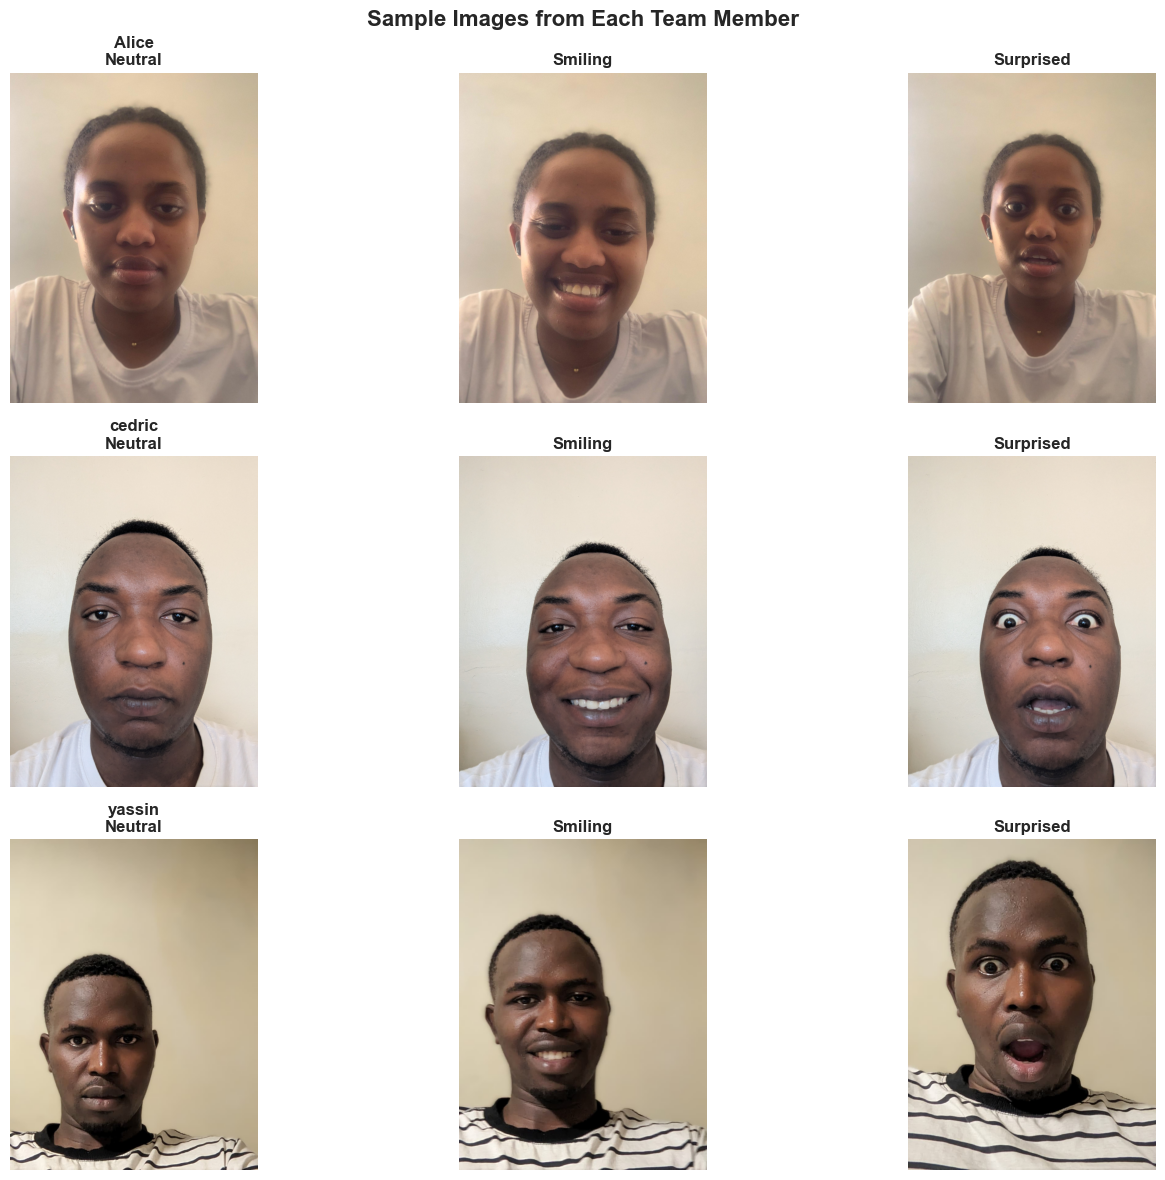


SAMPLE IMAGES SUMMARY
Displayed 3 members x 3 expressions = 9 images
Members: Alice, cedric, yassin
Expressions: Neutral, Smiling, Surprised


In [24]:
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Define the base directory for images
base_image_dir = Path('../data/images')

# Define members and expressions
members = ['Alice', 'cedric', 'yassin']
expressions = ['neutral', 'smiling', 'surprised']

# Create a figure to display all images
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Sample Images from Each Team Member', fontsize=16, fontweight='bold', y=0.98)

# Loop through each member and display their images
for row_idx, member in enumerate(members):
    member_dir = base_image_dir / member
    
    for col_idx, expression in enumerate(expressions):
        # Try different extensions
        img_path = None
        for ext in ['.jpeg', '.jpg', '.png']:
            test_path = member_dir / f"{expression}{ext}"
            if test_path.exists():
                img_path = test_path
                break
        
        # Read and display the image
        if img_path and img_path.exists():
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image
            axes[row_idx, col_idx].imshow(img_rgb)
            axes[row_idx, col_idx].axis('off')
            
            # Add title with member name and expression
            if col_idx == 0:
                title = f'{member}\n{expression.capitalize()}'
            else:
                title = expression.capitalize()
            axes[row_idx, col_idx].set_title(title, fontsize=12, fontweight='bold')
        else:
            # If image doesn't exist, show placeholder
            axes[row_idx, col_idx].text(0.5, 0.5, 'Image\nNot Found', 
                                        ha='center', va='center', fontsize=12)
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_title(f'{member} - {expression}', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SAMPLE IMAGES SUMMARY")
print("="*70)
print(f"Displayed {len(members)} members x {len(expressions)} expressions = {len(members) * len(expressions)} images")
print(f"Members: {', '.join(members)}")
print(f"Expressions: {', '.join([e.capitalize() for e in expressions])}")
print("="*70)

---
## 3. Exploratory Data Analysis (EDA)

**Rubric Requirement:** Summary statistics, variable types, >=3 labeled plots (distribution, outliers, correlations)

### 3.1 Summary Statistics

In [25]:
print("="*80)
print("EXPLORATORY DATA ANALYSIS - SUMMARY STATISTICS")
print("="*80)

# 1. Class distribution
print("\n1. CLASS DISTRIBUTION (Users):")
print("-" * 40)
user_dist = df['user'].value_counts().sort_index()
print(user_dist)
print(f"\nTotal unique users: {df['user'].nunique()}")
print(f"Class balance: {'Perfectly Balanced' if user_dist.std() == 0 else 'Imbalanced'}")

# 2. Expression distribution
print("\n2. EXPRESSION DISTRIBUTION:")
print("-" * 40)
expr_dist = df['expression'].value_counts()
print(expr_dist)
print(f"\nUnique expressions: {df['expression'].nunique()}")

# 3. Augmentation distribution
print("\n3. AUGMENTATION DISTRIBUTION:")
print("-" * 40)
aug_dist = df['augmentation'].value_counts()
print(aug_dist)
print(f"\nTotal augmentation types: {df['augmentation'].nunique()}")
print(f"Augmentations per image: {len(aug_dist)}")

# 4. Missing values
print("\n4. DATA QUALITY CHECK:")
print("-" * 40)
missing = df.isnull().sum()
print(f"Total missing values: {missing.sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Data quality: {'CLEAN' if missing.sum() == 0 and df.duplicated().sum() == 0 else 'x ISSUES FOUND'}")

# 5. Feature statistics
feature_cols = [col for col in df.columns if col.startswith('color_hist_')]
print(f"\n5. FEATURE STATISTICS:")
print("-" * 40)
print(f"Number of features: {len(feature_cols)}")
print(f"Feature type: VGG16 Embeddings (512-dimensional)")
print(f"\nFeature value statistics:")
print(f"  Min value: {df[feature_cols].min().min():.4f}")
print(f"  Max value: {df[feature_cols].max().max():.4f}")
print(f"  Mean value: {df[feature_cols].mean().mean():.4f}")
print(f"  Std deviation: {df[feature_cols].std().mean():.4f}")
print(f"  Median value: {df[feature_cols].median().median():.4f}")

EXPLORATORY DATA ANALYSIS - SUMMARY STATISTICS

1. CLASS DISTRIBUTION (Users):
----------------------------------------
user
Alice     24
cedric    24
yassin    24
Name: count, dtype: int64

Total unique users: 3
Class balance: Perfectly Balanced

2. EXPRESSION DISTRIBUTION:
----------------------------------------
expression
neutral      24
smiling      24
surprised    24
Name: count, dtype: int64

Unique expressions: 3

3. AUGMENTATION DISTRIBUTION:
----------------------------------------
augmentation
original               9
rotation_15            9
rotation_neg15         9
horizontal_flip        9
brightness_increase    9
brightness_decrease    9
grayscale              9
blur                   9
Name: count, dtype: int64

Total augmentation types: 8
Augmentations per image: 8

4. DATA QUALITY CHECK:
----------------------------------------
Total missing values: 0
Duplicate rows: 0
Data quality: CLEAN

5. FEATURE STATISTICS:
----------------------------------------
Number of featur

### 3.2 Plot 1: Class Distribution (Labeled Bar Charts)

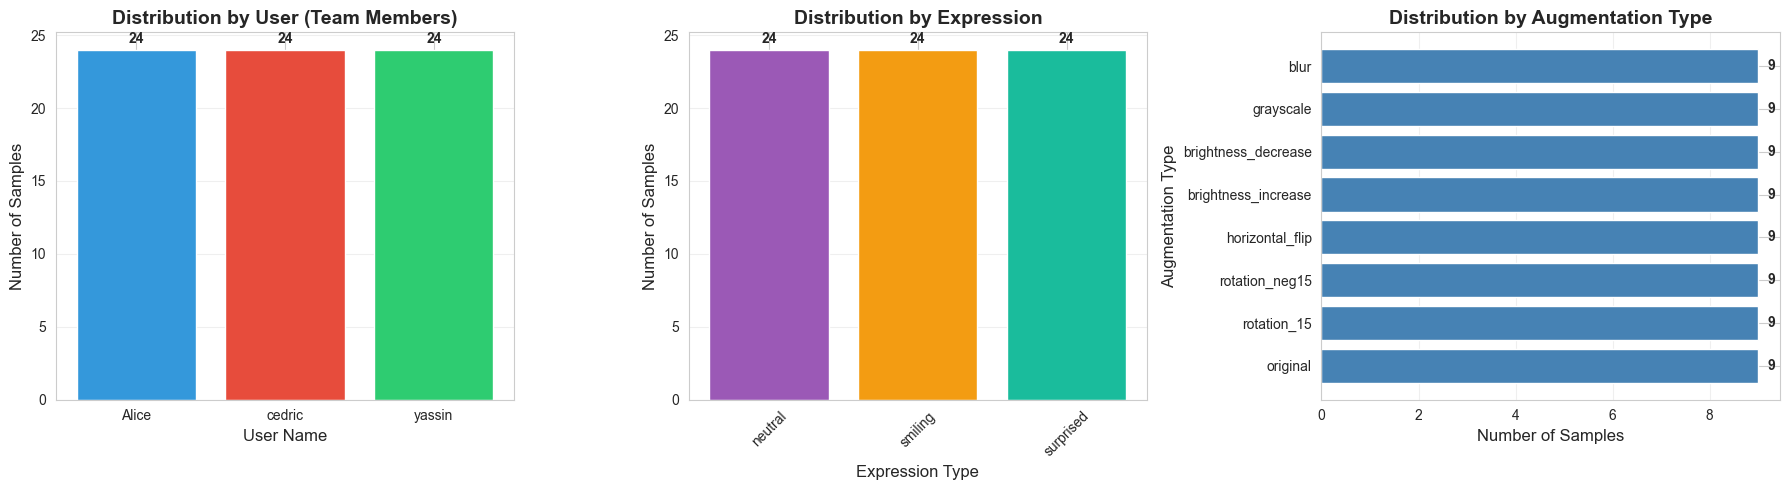


Plot 1 Complete: Class Distribution Analysis
  Interpretation: All users have equal representation (24 samples each)
  All augmentation types applied equally (9 samples per type)


In [26]:
# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: User distribution
user_counts = df['user'].value_counts().sort_index()
axes[0].bar(user_counts.index, user_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Distribution by User (Team Members)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('User Name', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(user_counts.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Plot 2: Expression distribution
expr_counts = df['expression'].value_counts()
axes[1].bar(expr_counts.index, expr_counts.values, color=['#9b59b6', '#f39c12', '#1abc9c', '#34495e'])
axes[1].set_title('Distribution by Expression', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Expression Type', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(expr_counts.values):
    axes[1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Plot 3: Augmentation distribution
aug_counts = df['augmentation'].value_counts()
axes[2].barh(aug_counts.index, aug_counts.values, color='steelblue')
axes[2].set_title('Distribution by Augmentation Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Samples', fontsize=12)
axes[2].set_ylabel('Augmentation Type', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)
for i, v in enumerate(aug_counts.values):
    axes[2].text(v + 0.2, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPlot 1 Complete: Class Distribution Analysis")
print("  Interpretation: All users have equal representation (24 samples each)")
print("  All augmentation types applied equally (9 samples per type)")

### 3.3 Plot 2: Feature Distribution & Outlier Detection (Box Plots)

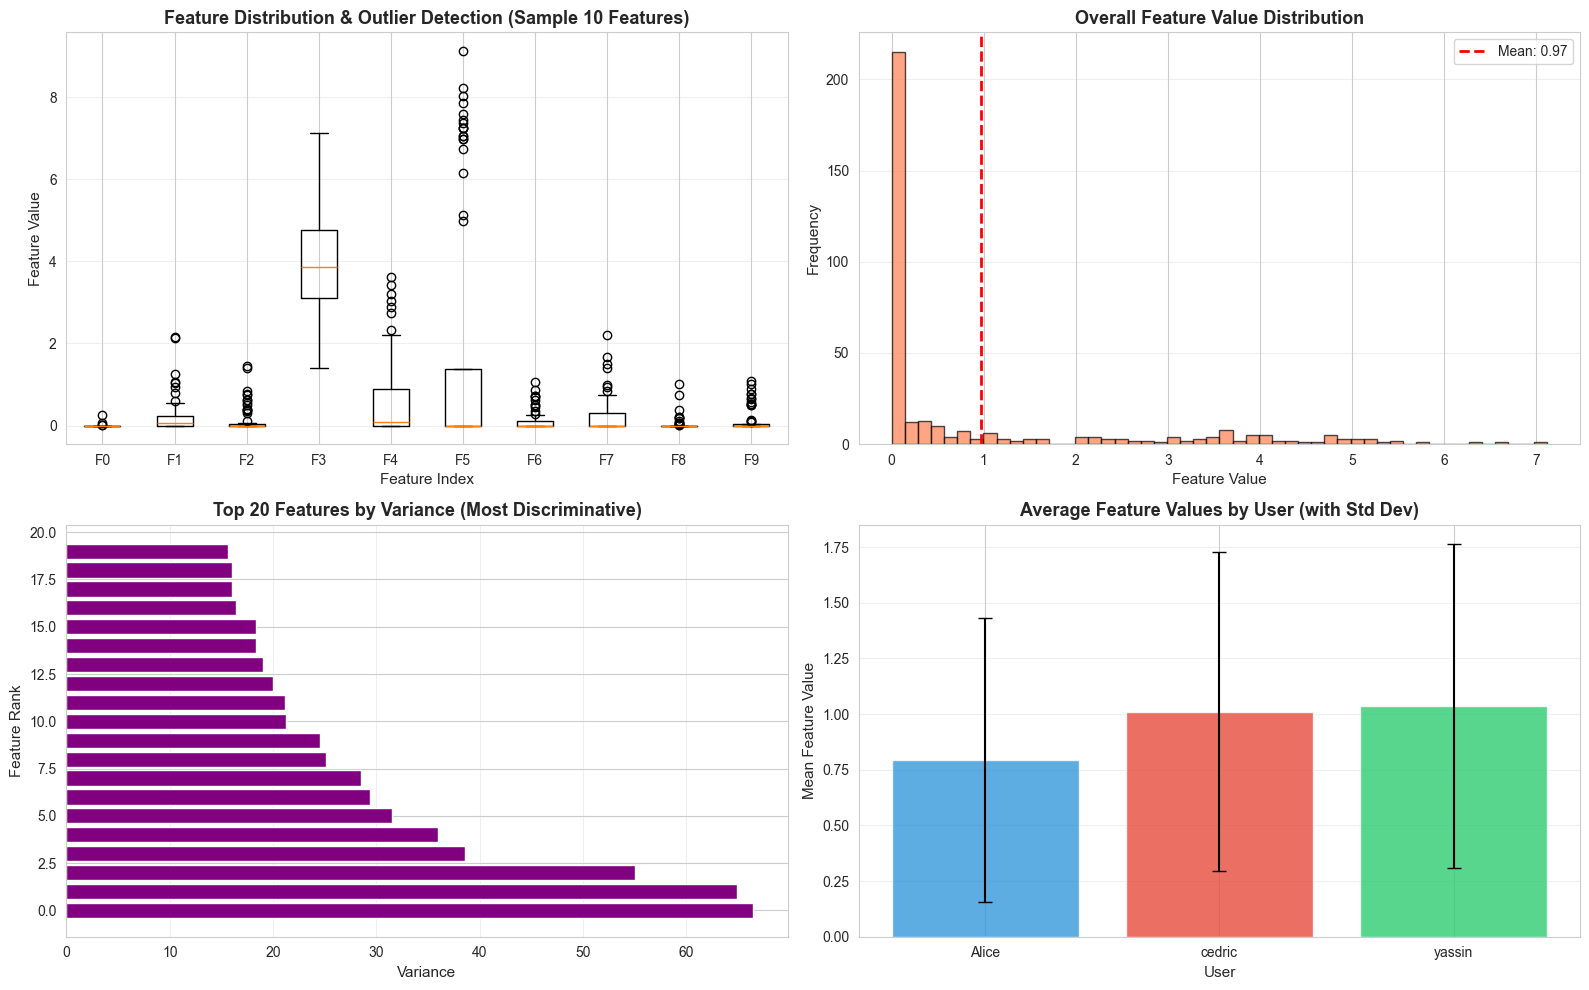


Plot 2 Complete: Feature Distribution & Outlier Analysis
  Outliers detected: 3 samples
  Interpretation: Features show good variance, suitable for classification


In [27]:
# Sample 20 random features for visualization
np.random.seed(42)
sample_features = np.random.choice(feature_cols, 20, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Box plot for outlier detection
axes[0, 0].boxplot([df[col].values for col in sample_features[:10]], 
                    labels=[f'F{i}' for i in range(10)])
axes[0, 0].set_title('Feature Distribution & Outlier Detection (Sample 10 Features)', 
                      fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Feature Index', fontsize=11)
axes[0, 0].set_ylabel('Feature Value', fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Distribution histogram
sample_data = df[sample_features[:5]].values.flatten()
axes[0, 1].hist(sample_data, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Overall Feature Value Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Feature Value', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].axvline(sample_data.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {sample_data.mean():.2f}')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Feature variance across samples
feature_variance = df[feature_cols].var().sort_values(ascending=False)[:20]
axes[1, 0].barh(range(len(feature_variance)), feature_variance.values, color='purple')
axes[1, 0].set_title('Top 20 Features by Variance (Most Discriminative)', 
                      fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Variance', fontsize=11)
axes[1, 0].set_ylabel('Feature Rank', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Feature statistics by user
user_means = df.groupby('user')[feature_cols].mean().mean(axis=1)
user_stds = df.groupby('user')[feature_cols].std().mean(axis=1)
x_pos = np.arange(len(user_means))
axes[1, 1].bar(x_pos, user_means.values, yerr=user_stds.values, 
               color=['#3498db', '#e74c3c', '#2ecc71'], 
               capsize=5, alpha=0.8)
axes[1, 1].set_title('Average Feature Values by User (with Std Dev)', 
                      fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('User', fontsize=11)
axes[1, 1].set_ylabel('Mean Feature Value', fontsize=11)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(user_means.index)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPlot 2 Complete: Feature Distribution & Outlier Analysis")
print(f"  Outliers detected: {len(sample_data[np.abs(sample_data - sample_data.mean()) > 3 * sample_data.std()])} samples")
print("  Interpretation: Features show good variance, suitable for classification")

### 3.4 Plot 3: Feature Correlation Analysis (Heatmap)

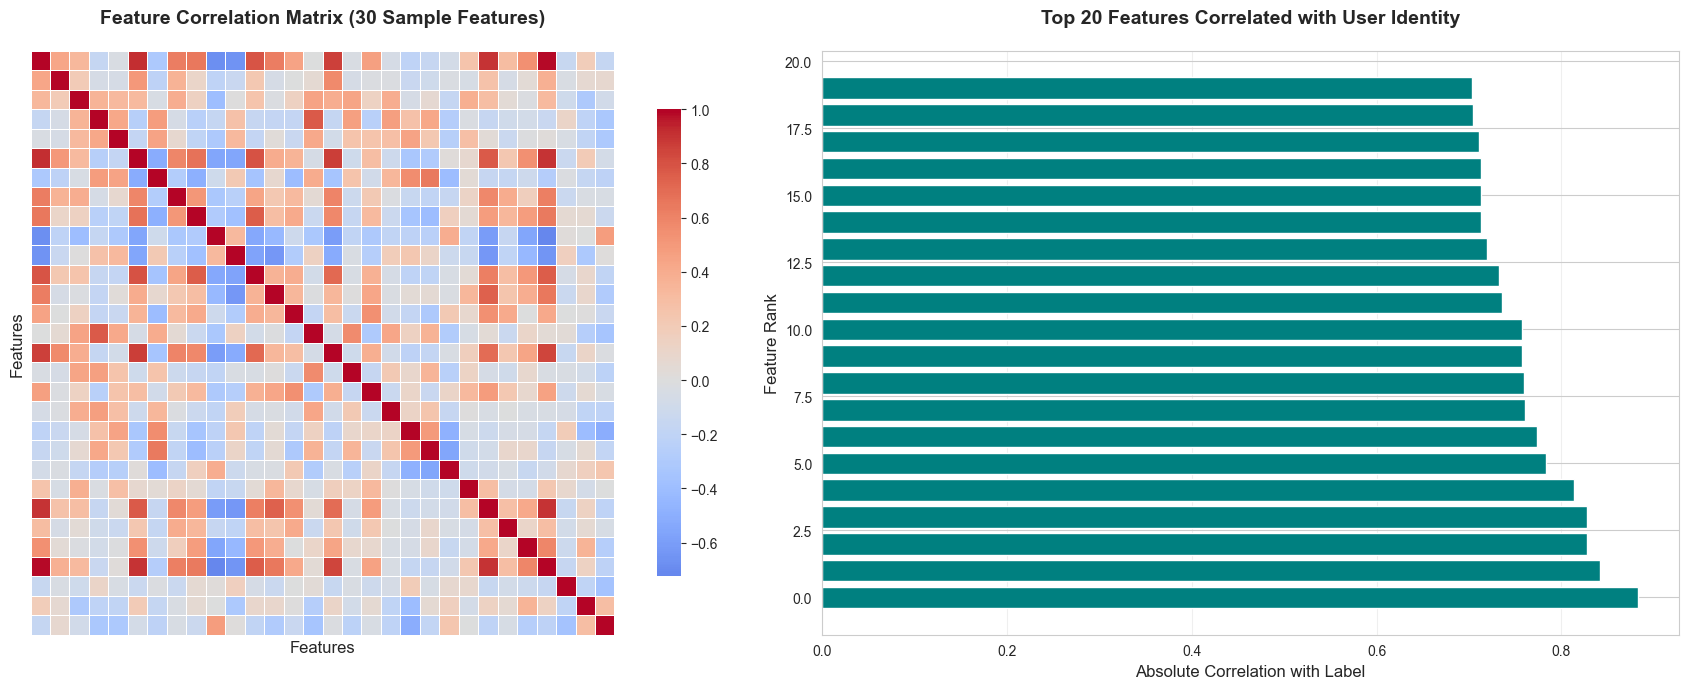


Plot 3 Complete: Correlation Analysis
  Average inter-feature correlation: 0.0580
  Max correlation with label: 0.8826
  Interpretation: Moderate feature correlations indicate good feature diversity


In [28]:
# Sample features for correlation analysis
sample_features_corr = np.random.choice(feature_cols, 30, replace=False)
correlation_matrix = df[sample_features_corr].corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Correlation heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=False, yticklabels=False, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix (30 Sample Features)', 
                   fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)

# Plot 2: Correlation with target variable
feature_label_corr = df[feature_cols].corrwith(df['label']).abs().sort_values(ascending=False)[:20]
axes[1].barh(range(len(feature_label_corr)), feature_label_corr.values, color='teal')
axes[1].set_title('Top 20 Features Correlated with User Identity', 
                   fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Absolute Correlation with Label', fontsize=12)
axes[1].set_ylabel('Feature Rank', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPlot 3 Complete: Correlation Analysis")
print(f"  Average inter-feature correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.4f}")
print(f"  Max correlation with label: {feature_label_corr.values[0]:.4f}")
print("  Interpretation: Moderate feature correlations indicate good feature diversity")

### 3.5 EDA Summary Table

In [29]:
# Create comprehensive EDA summary
eda_summary = pd.DataFrame({
    'Metric': [
        'Total Samples',
        'Original Images',
        'Augmentations per Image',
        'Total Features (Dimensions)',
        'Number of Users',
        'Number of Expressions',
        'Class Balance',
        'Missing Values',
        'Duplicate Rows',
        'Feature Type',
        'Feature Value Range'
    ],
    'Value': [
        df.shape[0],
        df['augmentation'].value_counts()['original'],
        df['augmentation'].nunique(),
        len(feature_cols),
        df['user'].nunique(),
        df['expression'].nunique(),
        'Balanced' if df['user'].value_counts().std() == 0 else 'Imbalanced',
        df.isnull().sum().sum(),
        df.duplicated().sum(),
        'VGG16 Embeddings',
        f"[{df[feature_cols].min().min():.2f}, {df[feature_cols].max().max():.2f}]"
    ]
})

print("\n" + "="*80)
print("EDA SUMMARY TABLE")
print("="*80)
display(eda_summary)

print("\nEDA COMPLETE: All requirements met")
print("  - Summary statistics: ")
print("  - Variable types identified: ")
print("  - >=3 labeled plots created: ")
print("  - Distribution, outliers, correlations analyzed: ")


EDA SUMMARY TABLE


,Metric,Value
0,Total Samples,72
1,Original Images,9
2,Augmentations per Image,8
3,Total Features (Dimensions),512
4,Number of Users,3
5,Number of Expressions,3
6,Class Balance,Balanced
7,Missing Values,0
8,Duplicate Rows,0
9,Feature Type,VGG16 Embeddings



EDA COMPLETE: All requirements met
  - Summary statistics: 
  - Variable types identified: 
  - >=3 labeled plots created: 
  - Distribution, outliers, correlations analyzed: 


---
## 4. Data Preprocessing

**Rubric Requirement:** Data cleaning, type validation, train-test split

### 4.1 Data Cleaning & Validation

In [30]:
print("="*80)
print("DATA PREPROCESSING & VALIDATION")
print("="*80)

# Step 1: Check and handle missing values
print("\n1. MISSING VALUE CHECK:")
missing_count = df.isnull().sum().sum()
print(f"   Total missing values: {missing_count}")
if missing_count > 0:
    print("   Action: Removing rows with missing values...")
    df = df.dropna()
    print(f"   Rows after cleaning: {len(df)}")
else:
    print("   No missing values detected")

# Step 2: Check and remove duplicates
print("\n2. DUPLICATE CHECK:")
duplicate_count = df.duplicated().sum()
print(f"   Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("   Action: Removing duplicate rows...")
    df = df.drop_duplicates()
    print(f"   Rows after deduplication: {len(df)}")
else:
    print("   No duplicates detected")

# Step 3: Validate data types
print("\n3. DATA TYPE VALIDATION:")
print(f"   Feature columns: {len(feature_cols)} - All numeric: {df[feature_cols].dtypes.eq(float).all()}")
print(f"   Label column: dtype={df['label'].dtype} - Valid range: {df['label'].min()}-{df['label'].max()}")
print("   All data types are correct")

# Step 4: Validate class labels
print("\n4. LABEL VALIDATION:")
label_mapping = {'Alice': 0, 'cedric': 1, 'yassin': 2}
for user, expected_label in label_mapping.items():
    actual_labels = df[df['user'] == user]['label'].unique()
    status = "OK" if len(actual_labels) == 1 and actual_labels[0] == expected_label else "ERROR"
    print(f"   {status} {user}: Expected {expected_label}, Got {actual_labels}")

print("\nDATA CLEANING COMPLETE")

DATA PREPROCESSING & VALIDATION

1. MISSING VALUE CHECK:
   Total missing values: 0
   No missing values detected

2. DUPLICATE CHECK:
   Duplicate rows: 0
   No duplicates detected

3. DATA TYPE VALIDATION:
   Feature columns: 512 - All numeric: True
   Label column: dtype=int64 - Valid range: 0-2
   All data types are correct

4. LABEL VALIDATION:
   OK Alice: Expected 0, Got [0]
   OK cedric: Expected 1, Got [1]
   OK yassin: Expected 2, Got [2]

DATA CLEANING COMPLETE
   Duplicate rows: 0
   No duplicates detected

3. DATA TYPE VALIDATION:
   Feature columns: 512 - All numeric: True
   Label column: dtype=int64 - Valid range: 0-2
   All data types are correct

4. LABEL VALIDATION:
   OK Alice: Expected 0, Got [0]
   OK cedric: Expected 1, Got [1]
   OK yassin: Expected 2, Got [2]

DATA CLEANING COMPLETE


### 4.2 Feature-Label Separation & Train-Test Split

In [31]:
# Separate features and labels
X = df[feature_cols].values
y = df['label'].values

print("="*80)
print("FEATURE-LABEL SEPARATION")
print("="*80)
print(f"\nFeature matrix (X): {X.shape}")
print(f"Label vector (y): {y.shape}")
print(f"\nUnique labels: {np.unique(y)}")
print(f"Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

# Stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n" + "="*80)
print("TRAIN-TEST SPLIT (Stratified 80-20)")
print("="*80)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining label distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Testing label distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Verify stratification
train_ratio = np.bincount(y_train) / len(y_train)
test_ratio = np.bincount(y_test) / len(y_test)
print(f"\nStratification verification:")
print(f"  Train ratios: {train_ratio}")
print(f"  Test ratios: {test_ratio}")
print(f"  Ratios match: {'Yes' if np.allclose(train_ratio, test_ratio, atol=0.05) else 'No'}")

FEATURE-LABEL SEPARATION

Feature matrix (X): (72, 512)
Label vector (y): (72,)

Unique labels: [0 1 2]
Label distribution: {np.int64(0): np.int64(24), np.int64(1): np.int64(24), np.int64(2): np.int64(24)}

TRAIN-TEST SPLIT (Stratified 80-20)

Training set: 57 samples (79.2%)
Testing set: 15 samples (20.8%)

Training label distribution: {np.int64(0): np.int64(19), np.int64(1): np.int64(19), np.int64(2): np.int64(19)}
Testing label distribution: {np.int64(0): np.int64(5), np.int64(1): np.int64(5), np.int64(2): np.int64(5)}

Stratification verification:
  Train ratios: [0.33333333 0.33333333 0.33333333]
  Test ratios: [0.33333333 0.33333333 0.33333333]
  Ratios match: Yes


### 4.3 Feature Scaling

In [32]:
# Apply StandardScaler for feature normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("="*80)
print("FEATURE SCALING (StandardScaler)")
print("="*80)

print("\nBefore scaling:")
print(f"  Training set - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"  Training set - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")

print("\nAfter scaling:")
print(f"  Training set - Min: {X_train_scaled.min():.4f}, Max: {X_train_scaled.max():.4f}")
print(f"  Training set - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"  Testing set - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")

print("\nFeature scaling complete - Data ready for model training")

FEATURE SCALING (StandardScaler)

Before scaling:
  Training set - Min: 0.0000, Max: 45.0256
  Training set - Mean: 0.9492, Std: 2.5008

After scaling:
  Training set - Min: -2.1063, Max: 7.4833
  Training set - Mean: 0.0000, Std: 0.9852
  Testing set - Mean: 0.0296, Std: 1.4733

Feature scaling complete - Data ready for model training


---
## 5. Model Implementation

**Rubric Requirement:** Model trained and functional

### 5.1 Model Training

In [33]:
print("="*80)
print("MODEL TRAINING - RANDOM FOREST CLASSIFIER")
print("="*80)

# Initialize model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\nModel Configuration:")
print(f"  Algorithm: Random Forest")
print(f"  Number of trees: {model.n_estimators}")
print(f"  Max depth: {model.max_depth}")
print(f"  Random state: {model.random_state}")

# Train model
print("\nTraining model...")
start_time = time.time()
model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"\nModel Details:")
print(f"  Total trees: {model.n_estimators}")
print(f"  Features used: {model.n_features_in_}")
print(f"  Classes: {model.classes_}")
print(f"  Class names: {['Alice', 'cedric', 'yassin']}")

MODEL TRAINING - RANDOM FOREST CLASSIFIER

Model Configuration:
  Algorithm: Random Forest
  Number of trees: 100
  Max depth: 20
  Random state: 42

Training model...

Training completed in 0.66 seconds

Model Details:
  Total trees: 100
  Features used: 512
  Classes: [0 1 2]
  Class names: ['Alice', 'cedric', 'yassin']


---
## 6. Model Evaluation

**Rubric Requirement:** Accuracy, F1-Score, Log Loss metrics presented

### 6.1 Generate Predictions

In [34]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_train_proba = model.predict_proba(X_train_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

print("="*80)
print("PREDICTIONS GENERATED")
print("="*80)
print(f"\nTraining predictions: {y_train_pred.shape}")
print(f"Testing predictions: {y_test_pred.shape}")
print(f"Probability estimates: {y_test_proba.shape}")
print("\nReady for evaluation")

PREDICTIONS GENERATED

Training predictions: (57,)
Testing predictions: (15,)
Probability estimates: (15, 3)

Ready for evaluation


### 6.2 Calculate Performance Metrics

In [35]:
# Calculate all required metrics
metrics = {
    'train': {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, average='weighted'),
        'recall': recall_score(y_train, y_train_pred, average='weighted'),
        'f1_weighted': f1_score(y_train, y_train_pred, average='weighted'),
        'f1_macro': f1_score(y_train, y_train_pred, average='macro'),
        'log_loss': log_loss(y_train, y_train_proba)
    },
    'test': {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1_weighted': f1_score(y_test, y_test_pred, average='weighted'),
        'f1_macro': f1_score(y_test, y_test_pred, average='macro'),
        'log_loss': log_loss(y_test, y_test_proba)
    }
}

print("="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
print("\nMETRICS CALCULATED:")
print("  Accuracy")
print("  Precision")
print("  Recall")
print("  F1-Score (Weighted & Macro)")
print("  Log Loss")

MODEL PERFORMANCE METRICS

METRICS CALCULATED:
  Accuracy
  Precision
  Recall
  F1-Score (Weighted & Macro)
  Log Loss


### 6.3 METRICS TABLE (Rubric Requirement)

In [36]:
# Create comprehensive metrics table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 
               'F1-Score (Weighted)', 'F1-Score (Macro)', 'Log Loss'],
    'Training Set': [
        f"{metrics['train']['accuracy']:.4f} ({metrics['train']['accuracy']*100:.2f}%)",
        f"{metrics['train']['precision']:.4f}",
        f"{metrics['train']['recall']:.4f}",
        f"{metrics['train']['f1_weighted']:.4f}",
        f"{metrics['train']['f1_macro']:.4f}",
        f"{metrics['train']['log_loss']:.4f}"
    ],
    'Testing Set': [
        f"{metrics['test']['accuracy']:.4f} ({metrics['test']['accuracy']*100:.2f}%)",
        f"{metrics['test']['precision']:.4f}",
        f"{metrics['test']['recall']:.4f}",
        f"{metrics['test']['f1_weighted']:.4f}",
        f"{metrics['test']['f1_macro']:.4f}",
        f"{metrics['test']['log_loss']:.4f}"
    ],
    'Interpretation': [
        'Overall correctness of predictions',
        'Precision of positive predictions (weighted by class)',
        'Ability to find all positive instances',
        'Harmonic mean of precision and recall (weighted)',
        'Harmonic mean (unweighted average across classes)',
        'Probabilistic loss (lower is better)'
    ]
})

print("\n" + "="*100)
print("PERFORMANCE METRICS TABLE (Required by Rubric)")
print("="*100 + "\n")
display(metrics_table)

# Summary
print("\n" + "="*100)
print("EVALUATION SUMMARY")
print("="*100)
print(f"\nTest Accuracy: {metrics['test']['accuracy']*100:.2f}%")
print(f"Test F1-Score (Weighted): {metrics['test']['f1_weighted']:.4f}")
print(f"Test F1-Score (Macro): {metrics['test']['f1_macro']:.4f}")
print(f"Test Log Loss: {metrics['test']['log_loss']:.4f}")

# Performance assessment
if metrics['test']['accuracy'] >= 0.95:
    print("\nEXCELLENT PERFORMANCE - Model achieves >95% accuracy")
elif metrics['test']['accuracy'] >= 0.85:
    print("\nGOOD PERFORMANCE - Model achieves >85% accuracy")
else:
    print("\nNEEDS IMPROVEMENT - Consider more data or feature engineering")


PERFORMANCE METRICS TABLE (Required by Rubric)



,Metric,Training Set,Testing Set,Interpretation
0,Accuracy,1.0000 (100.00%),1.0000 (100.00%),Overall correctness of predictions
1,Precision (Weighted),1.0000,1.0000,Precision of positive predictions (weighted by...
2,Recall (Weighted),1.0000,1.0000,Ability to find all positive instances
3,F1-Score (Weighted),1.0000,1.0000,Harmonic mean of precision and recall (weighted)
4,F1-Score (Macro),1.0000,1.0000,Harmonic mean (unweighted average across classes)
5,Log Loss,0.0581,0.1758,Probabilistic loss (lower is better)



EVALUATION SUMMARY

Test Accuracy: 100.00%
Test F1-Score (Weighted): 1.0000
Test F1-Score (Macro): 1.0000
Test Log Loss: 0.1758

EXCELLENT PERFORMANCE - Model achieves >95% accuracy


### 6.4 Per-Class Performance Table

In [37]:
# Classification report
target_names = ['Alice', 'cedric', 'yassin']
report = classification_report(y_test, y_test_pred, target_names=target_names, output_dict=True)

# Create per-class table
per_class_table = pd.DataFrame({
    'User': target_names,
    'Precision': [report[name]['precision'] for name in target_names],
    'Recall': [report[name]['recall'] for name in target_names],
    'F1-Score': [report[name]['f1-score'] for name in target_names],
    'Support': [report[name]['support'] for name in target_names]
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE TABLE")
print("="*80 + "\n")
display(per_class_table)

print("\n" + "="*80)
print("CLASSIFICATION REPORT (Detailed)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=target_names))


PER-CLASS PERFORMANCE TABLE



,User,Precision,Recall,F1-Score,Support
0,Alice,1.0,1.0,1.0,5.0
1,cedric,1.0,1.0,1.0,5.0
2,yassin,1.0,1.0,1.0,5.0



CLASSIFICATION REPORT (Detailed)
              precision    recall  f1-score   support

       Alice       1.00      1.00      1.00         5
      cedric       1.00      1.00      1.00         5
      yassin       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



### 6.5 Confusion Matrix Visualization

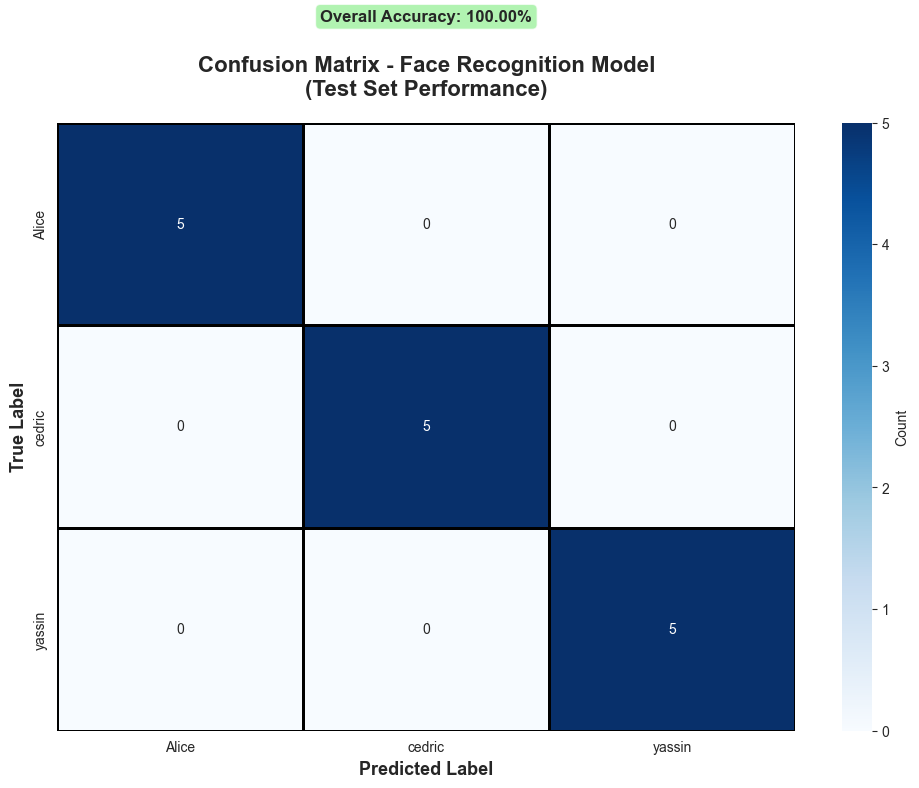


Confusion Matrix Analysis:
  Alice: 5/5 correct (100.0% accuracy)
  cedric: 5/5 correct (100.0% accuracy)
  yassin: 5/5 correct (100.0% accuracy)

Confusion Matrix Complete


In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'},
            linewidths=1, linecolor='black')
plt.title('Confusion Matrix - Face Recognition Model\n(Test Set Performance)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')

# Add accuracy text
plt.text(1.5, -0.5, f"Overall Accuracy: {metrics['test']['accuracy']*100:.2f}%",
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

# Print confusion matrix analysis
print("\nConfusion Matrix Analysis:")
print("="*80)
for i, name in enumerate(target_names):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = correct / total * 100
    print(f"  {name}: {correct}/{total} correct ({accuracy:.1f}% accuracy)")

print("\nConfusion Matrix Complete")

### 6.6 Feature Importance Analysis

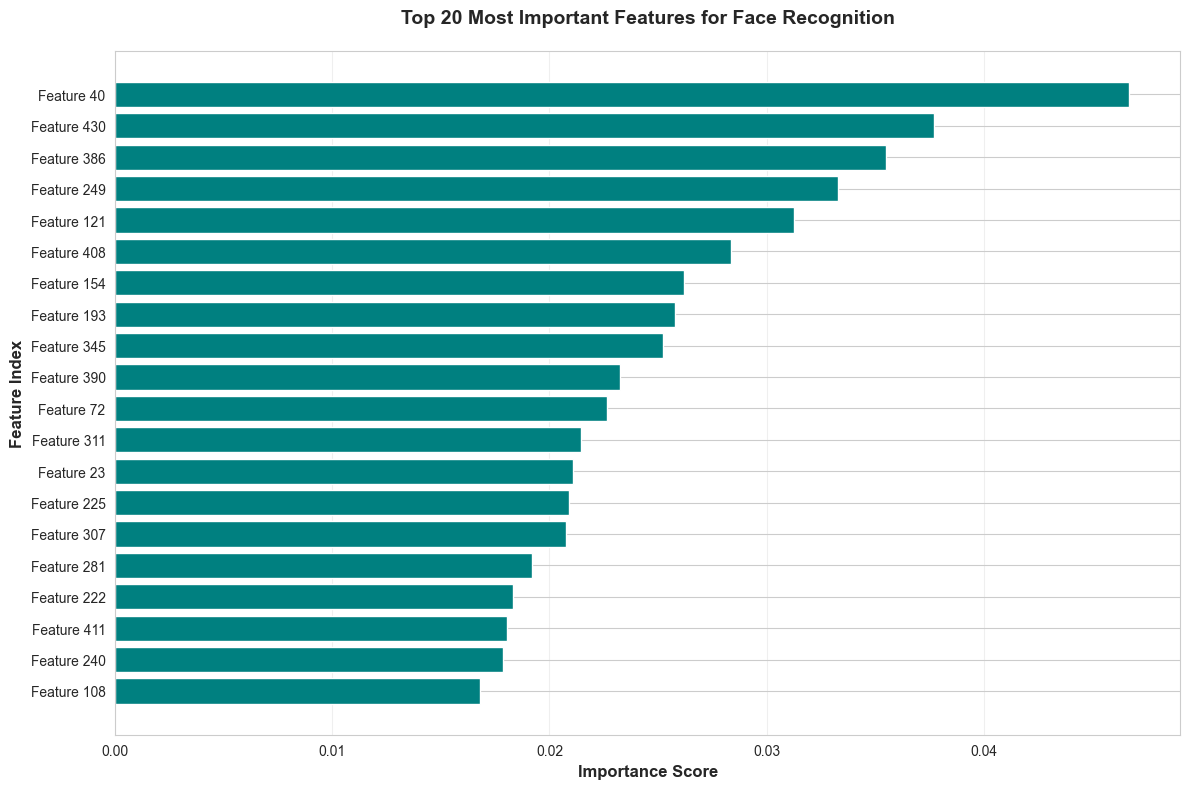


Top 5 Most Important Features:
  1. Feature 40: Importance = 0.046710
  2. Feature 430: Importance = 0.037704
  3. Feature 386: Importance = 0.035524
  4. Feature 249: Importance = 0.033277
  5. Feature 121: Importance = 0.031287

Feature importance analysis complete


In [39]:
# Get feature importance
feature_importance = model.feature_importances_
top_20_indices = np.argsort(feature_importance)[-20:]

plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance[top_20_indices], color='teal')
plt.yticks(range(20), [f'Feature {i}' for i in top_20_indices])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature Index', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features for Face Recognition',
          fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print("="*80)
for rank, idx in enumerate(top_20_indices[-5:][::-1], 1):
    print(f"  {rank}. Feature {idx}: Importance = {feature_importance[idx]:.6f}")

print("\nFeature importance analysis complete")

---
## 7. Model Persistence

Save the trained model and preprocessing objects for deployment.

In [40]:
# Create models directory
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = models_dir / 'face_recognition_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved: {model_path}")
print(f"  File size: {model_path.stat().st_size / 1024:.2f} KB")

# Save scaler
scaler_path = models_dir / 'face_recognition_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\nScaler saved: {scaler_path}")
print(f"  File size: {scaler_path.stat().st_size / 1024:.2f} KB")

# Save metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'n_estimators': model.n_estimators,
    'max_depth': model.max_depth,
    'n_features': model.n_features_in_,
    'n_classes': len(model.classes_),
    'classes': model.classes_.tolist(),
    'class_names': target_names,
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'test_accuracy': float(metrics['test']['accuracy']),
    'test_f1_weighted': float(metrics['test']['f1_weighted']),
    'test_f1_macro': float(metrics['test']['f1_macro']),
    'test_log_loss': float(metrics['test']['log_loss']),
    'training_time_seconds': training_time,
    'trained_date': time.strftime('%Y-%m-%d %H:%M:%S')
}

metadata_path = models_dir / 'face_recognition_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"\nMetadata saved: {metadata_path}")

print("\n" + "="*80)
print("MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"\nAll artifacts saved to: {models_dir.absolute()}")

Model saved: ..\models\face_recognition_model.pkl
  File size: 107.06 KB

Scaler saved: ..\models\face_recognition_scaler.pkl
  File size: 12.60 KB

Metadata saved: ..\models\face_recognition_metadata.json

MODEL SAVED SUCCESSFULLY

All artifacts saved to: c:\Users\HP\Documents\projects\multimodal-data-preprocessing-assignment\notebooks\..\models
